<a href="https://colab.research.google.com/github/sujaysavanth/statisticsfordata/blob/main/Hypothesis1_CityEnergyCorrelation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 📘 Hypothesis 1: Do Larger Cities Consume More Energy?
This notebook investigates the relationship between city population and energy consumption.

#### 🧩 Step 1: Load and Preprocess the Data

In [16]:
# STEP 0: Install if needed
!pip install pyxlsb

# STEP 1: Load and clean original sheet
import pandas as pd

file_path = "/content/2016cityandcountyenergyprofiles (1).xlsb"
city_data = pd.read_excel(file_path, engine='pyxlsb', sheet_name='City', skiprows=1)

# STEP 2: Fix headers and clean up
city_data.columns = city_data.iloc[2]
city_data = city_data.drop([0, 1, 2]).reset_index(drop=True)

# STEP 3: Print to find column counts (for sanity check)
print("Column count:", len(city_data.columns))
print("Top duplicate names:\n", pd.Series(city_data.columns).value_counts().head(10))

# STEP 4: Build clean dataset using first unique MWh and TcF columns (use index not name)
city_df = pd.DataFrame()
city_df['city_name'] = city_data['city_name']
city_df['state'] = city_data['state_abbr']
city_df['population'] = pd.to_numeric(city_data['population'], errors='coerce')

# Get the *first* index of 'consumption (MWh)' and 'consumption (TcF)' columns
mwh_index = list(city_data.columns).index('consumption (MWh)')
tcf_index = list(city_data.columns).index('consumption (TcF)')

# Use iloc to extract exact Series, not DataFrame
city_df['electricity_MWh'] = pd.to_numeric(city_data.iloc[:, mwh_index], errors='coerce')
city_df['natural_gas_TcF'] = pd.to_numeric(city_data.iloc[:, tcf_index], errors='coerce')

# STEP 5: Drop NAs and compute total energy
city_df.dropna(inplace=True)
city_df['total_energy_MWh'] = city_df['electricity_MWh'] + city_df['natural_gas_TcF'] * 293071
print(city_df.head)


Column count: 169
Top duplicate names:
 2
expenditures ('000 $)                                      82
consumption (MWh)                                          30
GHG emissions (mtons CO2e)                                  8
expenditures ('000 $/capita)                                6
utility customers                                           4
consumption (TcF)                                           4
consumption (TcF/capita)                                    3
consumption (MWh/capita)                                    3
consumption (gallons/capita)                                2
CO2 equivalent total output emission rate (mton/gallon)     2
Name: count, dtype: int64
<bound method NDFrame.head of              city_name state  population  electricity_MWh  natural_gas_TcF  \
0       Abbeville city    AL      2627.0     15136.510694      3198.203890   
1      Adamsville city    AL      4422.0     23734.968596     44649.386034   
2         Addison town    AL       757.0      41

#### 📊 Step 2: Check Distributions (Histograms + Shapiro-Wilk Test)

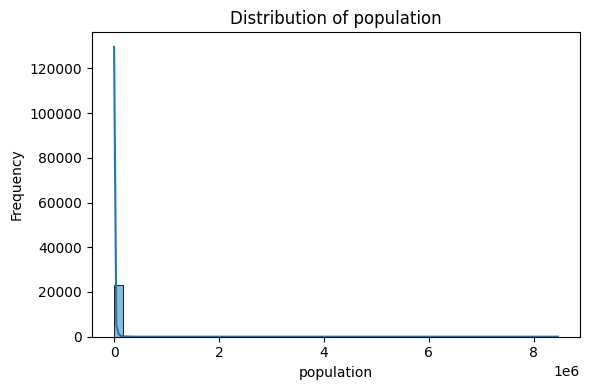


Shapiro-Wilk Test for 'population': W=0.1368, p=0.0000
⚠️ 'population' is NOT normally distributed.



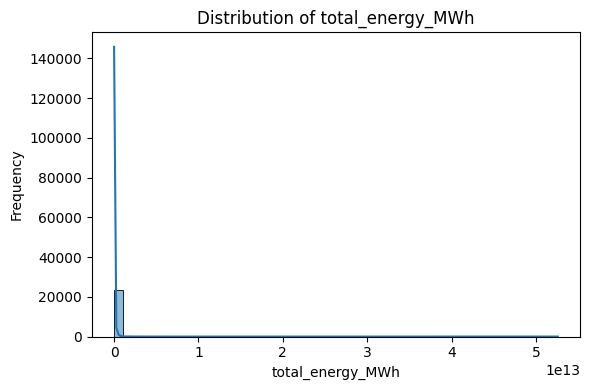


Shapiro-Wilk Test for 'total_energy_MWh': W=0.1516, p=0.0000
⚠️ 'total_energy_MWh' is NOT normally distributed.



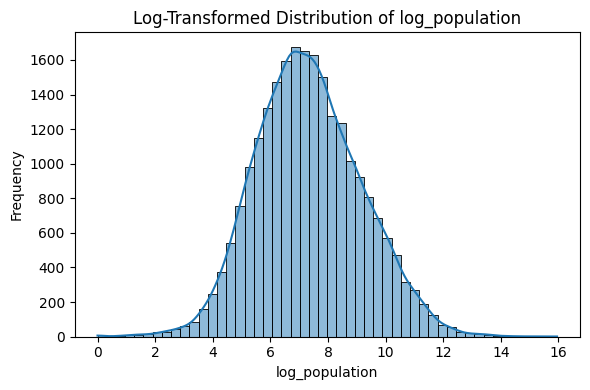


Shapiro-Wilk Test for 'log_population': W=0.9884, p=0.0005
⚠️ 'log_population' is still not normally distributed.



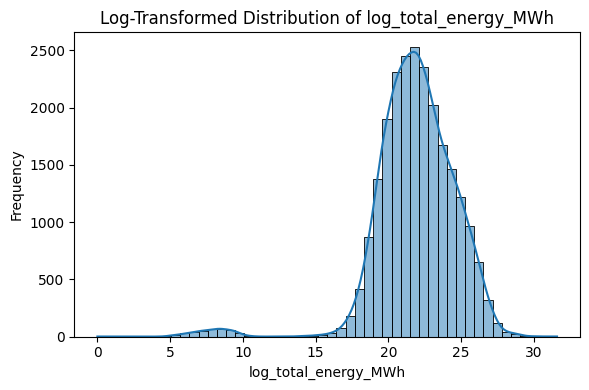


Shapiro-Wilk Test for 'log_total_energy_MWh': W=0.8634, p=0.0000
⚠️ 'log_total_energy_MWh' is still not normally distributed.



In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

# Original distribution and Shapiro-Wilk
for col in ['population', 'total_energy_MWh']:
    plt.figure(figsize=(6, 4))
    sns.histplot(city_df[col], kde=True, bins=50)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    stat, p = shapiro(city_df[col].sample(500, random_state=42))
    print(f"\nShapiro-Wilk Test for '{col}': W={stat:.4f}, p={p:.4f}")
    if p > 0.05:
        print(f"'{col}' appears to be normally distributed.\n")
    else:
        print(f"'{col}' is NOT normally distributed.\n")

# LOG TRANSFORMATION and re-check distribution


# Apply log1p safely
city_df['log_population'] = np.log1p(city_df['population'])
city_df['log_total_energy_MWh'] = np.log1p(city_df['total_energy_MWh'])

# Log-transformed distributions
for col in ['log_population', 'log_total_energy_MWh']:
    plt.figure(figsize=(6, 4))
    sns.histplot(city_df[col], kde=True, bins=50)
    plt.title(f'Log-Transformed Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    stat, p = shapiro(city_df[col].sample(500, random_state=42))
    print(f"\nShapiro-Wilk Test for '{col}': W={stat:.4f}, p={p:.4f}")
    if p > 0.05:
        print(f"'{col}' now appears to be normally distributed.\n")
    else:
        print(f"'{col}' is still not normally distributed.\n")


#### 📈 Step 3: Choose and Run Correlation Test

In [15]:
from scipy.stats import spearmanr, pearsonr

print("🔹 Correlation on ORIGINAL Data (ONLY Spearman):")
s_corr, s_pval = spearmanr(city_df['population'], city_df['total_energy_MWh'])
print(f"Spearman (original): r = {s_corr:.4f}, p = {s_pval:.4f}")
if s_pval < 0.05:
    print("Statistically significant (non-parametric)\n")
else:
    print("Not statistically significant (non-parametric)\n")

print("🔹 Correlation on LOG-TRANSFORMED Data (Pearson + Spearman):")
# Spearman (log)
s_log_corr, s_log_pval = spearmanr(city_df['log_population'], city_df['log_total_energy_MWh'])
print(f"Spearman (log-log): r = {s_log_corr:.4f}, p = {s_log_pval:.4f}")
if s_log_pval < 0.05:
    print("Statistically significant (non-parametric, log-log)\n")
else:
    print(" Not statistically significant (non-parametric, log-log)\n")

# Pearson (log-log)
p_log_corr, p_log_pval = pearsonr(city_df['log_population'], city_df['log_total_energy_MWh'])
print(f"Pearson  (log-log): r = {p_log_corr:.4f}, p = {p_log_pval:.4f}")
if p_log_pval < 0.05:
    print("Statistically significant (parametric, log-log)\n")
else:
    print("Not statistically significant (parametric, log-log)\n")


🔹 Correlation on ORIGINAL Data (ONLY Spearman):
📊 Spearman (original): r = 0.8561, p = 0.0000
✅ Statistically significant (non-parametric)

🔹 Correlation on LOG-TRANSFORMED Data (Pearson + Spearman):
📊 Spearman (log-log): r = 0.8561, p = 0.0000
✅ Statistically significant (non-parametric, log-log)

📈 Pearson  (log-log): r = 0.7131, p = 0.0000
✅ Statistically significant (parametric, log-log)

